# Zone Temperature Dynamical Model

Goals:
- investigate different physics-informed dynamical models for zone temperature prediction
- thermal dynamics should be captured

In [1]:
from jax import config 
config.update("jax_debug_nans", False)
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np

import jax 
import jax.numpy as jnp 
import flax.linen as nn
import optax 
import pandas as pd 

from dynax.core.base_block_state_space import BaseContinuousBlockSSM
from dynax.simulators.simulator import DifferentiableSimulator
from dynax.trainer.train_state import TrainState

## 0. Data and DataLoader
- EP data with prototypical building model
- Real data from Lennox thermostat data

In [2]:
"""
import pandas as pd 

dates = ['01-'+str(i)+'-18' for i in range(14, 28)]
data = pd.read_excel('./data/real-world-data.xls', sheet_name=dates, header=3)

combined_data = pd.DataFrame()
for key in data.keys():
    combined_data = pd.concat([combined_data, data[key]], axis=0, ignore_index=True)

combined_data.to_csv('./data/real-world-data.csv')
"""

"\nimport pandas as pd \n\ndates = ['01-'+str(i)+'-18' for i in range(14, 28)]\ndata = pd.read_excel('./data/real-world-data.xls', sheet_name=dates, header=3)\n\ncombined_data = pd.DataFrame()\nfor key in data.keys():\n    combined_data = pd.concat([combined_data, data[key]], axis=0, ignore_index=True)\n\ncombined_data.to_csv('./data/real-world-data.csv')\n"

In [3]:
data = pd.read_csv('./data/real-world-data.csv')

columns_mapper = {'LocalTime':'time', 'tabtsense0':'temp_zone', 'SP_cool':'csp', 'SP_heat':'hsp', 'CoolDemand':'qcool', 'HeatDemand':'qheat', 'humidityindoor_0':'rh_zone', 'oupresentcompressorfreq':'freq', 'iuairflowrate':'cfm', 'surf_tempf':'temp_out', 'rad':'qsol'}

data = data[columns_mapper.keys()].rename(columns = columns_mapper)
data.index = pd.DatetimeIndex(data['time'], freq='1min')
data = data.drop(columns=['time'])


In [4]:
data.head()

,temp_zone,csp,hsp,qcool,qheat,rh_zone,freq,cfm,temp_out,qsol
time,,,,,,,,,,
2018-01-14 18:01:00,69.6,77,70,0,100,35.5,NaN,0,41.531667,0.0
2018-01-14 18:02:00,69.5,77,70,0,100,36.0,NaN,0,41.563333,0.0
2018-01-14 18:03:00,69.5,77,70,0,100,36.0,NaN,0,41.595000,0.0
2018-01-14 18:04:00,69.6,77,70,0,100,36.0,NaN,0,41.626667,0.0
2018-01-14 18:05:00,69.6,77,70,0,100,36.0,NaN,0,41.658333,0.0


This data is from Rohini's house, which has a Lennox thermostat but Carrier unit. Thus the equipment info are basically not available. 
- assume nominal heating capacity is 4 ton (e.g., 14 kW)

In [5]:
# change IP unit to SI
# F to C
data[['temp_zone', 'csp', 'hsp', 'temp_out']] =  5./9*(data[['temp_zone', 'csp', 'hsp', 'temp_out']] - 32)
# W to kW
data['qsol'] /= 1000.
# percentage to kW
data[['qcool', 'qheat']] *= 14./100.

data['qhvac'] = -1*data['qcool'] + data['qheat']

In [6]:
# resampel to 15min 
data = data.resample('15min').mean()
data.head()

,temp_zone,csp,hsp,qcool,qheat,rh_zone,freq,cfm,temp_out,qsol,qhvac
time,,,,,,,,,,,
2018-01-14 18:00:00,21.206349,25.0,21.111111,0.0,7.0,35.178571,NaN,0.0,5.409722,0.0,7.0
2018-01-14 18:15:00,21.618519,25.0,21.111111,0.0,0.0,33.733333,NaN,0.0,5.664815,0.0,0.0
2018-01-14 18:30:00,21.329630,25.0,21.111111,0.0,0.0,35.333333,NaN,0.0,5.928704,0.0,0.0
2018-01-14 18:45:00,21.125926,25.0,21.111111,0.0,0.0,36.000000,NaN,0.0,6.192593,0.0,0.0
2018-01-14 19:00:00,21.118519,25.0,21.111111,0.0,0.0,36.333333,NaN,0.0,6.268519,0.0,0.0


In [7]:
# time features
def add_time_features(data):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    return data

# use cos and sin to encode cyclical features
def encode_cyclical(data, col, max_val):
    data[col+'_sin'] = np.sin(2*np.pi*data[col]/max_val)
    data[col+'_cos'] = np.cos(2*np.pi*data[col]/max_val)
    return data


In [8]:
target_col = ["temp_zone"]
outdoor_col = ["temp_out", "qsol"]
control_col = ["qhvac"]
feature = target_col + outdoor_col + control_col

data = data[feature]

# add time features
data = add_time_features(data)
data = encode_cyclical(data, "hour", 23)
data = encode_cyclical(data, "dayofweek", 6)
time_feature = ["hour_sin", "hour_cos", "dayofweek_sin", "dayofweek_cos"]

data = data[feature + time_feature]
data.head()

,temp_zone,temp_out,qsol,qhvac,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos
time,,,,,,,,
2018-01-14 18:00:00,21.206349,5.409722,0.0,7.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 18:15:00,21.618519,5.664815,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 18:30:00,21.329630,5.928704,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 18:45:00,21.125926,6.192593,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 19:00:00,21.118519,6.268519,0.0,0.0,-0.887885,0.460065,-2.449294e-16,1.0


#### Prepare Data

`states`: $T_z$

`inputs`: $(\dot q_{hvac}|_{t}^{t+H}, (t, \dot q_{sol}, T_{out})|_{t-P}^{t+H})$

In [10]:
# lag features 
n_lags = 1
n_futures = 1

# shift for future steps
target = data[target_col].shift(-n_futures)
target.columns = [col+'_next' for col in target.columns]
data = pd.concat([data, target], axis=1).dropna()

# split for training and validation and testing
split_ratio = [0.7, 0.15, 0.15]
n_samples = data.shape[0]
n_train = int(n_samples * split_ratio[0])
n_val = int(n_samples * split_ratio[1])
n_test = n_samples - n_train - n_val

train_data = data.iloc[:n_train]
val_data = data.iloc[n_train:n_train+n_val]
test_data = data.iloc[n_train+n_val:]



## 1. Models



In [30]:
def mse(y_true, y_pred):
    return jnp.mean(jnp.square(y_true - y_pred))

def rmse(y_true, y_pred):
    return jnp.sqrt(mse(y_true, y_pred))


### 1.1 Baseline Model

This model simply predicts the next steo using the current step value

In [34]:
# train loss
y_pred_train = train_data[target_col].values
y_target_train = train_data[[col+'_next' for col in target_col]].values
mse_train = mse(y_target_train, y_pred_train)
rmse_train = rmse(y_target_train, y_pred_train)

# val loss
y_pred_val = val_data[target_col].values
y_target_val = val_data[[col+'_next' for col in target_col]].values
mse_val = mse(y_target_val, y_pred_val)
rmse_val = rmse(y_target_val, y_pred_val)

# test loss 
y_pred_test = test_data[target_col].values
y_target_test = test_data[[col+'_next' for col in target_col]].values
mse_test = mse(y_target_test, y_pred_test)
rmse_test = rmse(y_target_test, y_pred_test)

print("Baseline model: ")
print(f"Train MSE: {mse_train:.4f}, Val MSE: {mse_val:.4f}, Test MSE: {mse_test:.4f}")
print(f"Train RMSE: {rmse_train:.4f}, Val RMSE: {rmse_val:.4f}, Test RMSE: {rmse_test:.4f}")


Baseline model: 
Train MSE: 0.0591, Val MSE: 0.0736, Test MSE: 0.0391
Train RMSE: 0.2431, Val RMSE: 0.2713, Test RMSE: 0.1978


### 1.2 Physics-informed Neural ODE

In this section, I will use physics-informed neural ODE to learn the dynamics of the system.

$$

    mC_{p,a}\frac{dT_z}{dt} = q_{hvac} + q_{int} + q_{intz} + q_{inf} + q_{surf}
$$

or 

$$
    \frac{dT_z}{dt} = \frac{1}{C}(q_{hvac} + q_{inf} + q_{int} + q_{intz} + q_{surf})  
$$

$$
    \frac{dT_z}{dt} = a \dot q_{hvac} + b (T_{out} - T_z) + c(T_{z,i} - T_z) + \frac{1}{C} (\dot q_{int} + \dot q_{surf}) =  a \dot q_{hvac} + b (T_{out} - T_z) + c(T_{z,i} - T_z) + D_{ann}(t, \dot q_{sol}, T_{out}) = -(b+c)T_z + a\dot q_{hvac} + bT_{out} + cT_{z,i} + D_{ann}(t, \dot q_{sol}, T_{out})

$$

Here we wll model this in dynax as a differentiable equation.

To simplify for residential buildings, where there is typically one zone, we can set $c=0$.


**Thoughts to try**:
- the $a, b, c$ might be too small, here I use the inverse
- the influence of solar/internal heat gain should not depend on zone temperature. Therefore, the nonlinear disturbance has no dependency on states.
- try out physics-informed deep koopman modeling


Discretetize the continous-time model using forward Euler method, we have

$$
    T_{z, t+1} = (1-b-c)T_{z,t} + a\dot q_{hvac, t} + bT_{out, t} + cT_{z,i,t} + D_{ann}(t, \dot q_{sol}, T_{out})
$$


#### Define Model

In [35]:
class Model(nn.Module):
    state_dim: int
    control_dim: int
    disturb_dim: int
    
    a_init = nn.initializers.ones_init()
    b_init = nn.initializers.zeros_init()
    

    @nn.compact
    def __call__(self, prev_state, u, d):
        # prev_state: (batch, state_dim)
        # u: (batch, control_dim)
        # d: (batch, disturb_dim)
        # TODO: why not working?
        #b = self.param('b', self.b_init, (self.state_dim, self.state_dim))
        #a = self.param('a', self.a_init, (self.control_dim, self.state_dim))
        b = self.param('b', nn.initializers.zeros_init(), (self.state_dim, self.state_dim))
        a = self.param('a', nn.initializers.ones_init(), (self.control_dim, self.state_dim))

        # disturbance model
        x = nn.Dense(self.disturb_dim, kernel_init=nn.initializers.lecun_normal(), use_bias=True)(d)
        # leaky relu layer
        x = nn.activation.leaky_relu(x)
        x = nn.Dense(self.state_dim)(x) # one state_dim
        
        # prediction
        au = jnp.einsum('bi,ij->bj', u, a)
        bd = jnp.einsum('bi,ij->bj', d[:, -1].reshape(-1,self.state_dim), b)
        x_prev = jnp.einsum('bi,ij->bj', prev_state, (1-b))
        
        x = x_prev + au + bd + x

        return x

In [36]:
model = Model(state_dim=1, control_dim=1, disturb_dim=6)

key = jax.random.PRNGKey(2023)
init_params = model.init(key, jnp.ones((4, 1)), jnp.zeros((4, 1)), jnp.ones((4, 6)))
init_out = model.apply(init_params, jnp.ones((4, 1)), jnp.zeros((4, 1)), jnp.ones((4, 6)))
print(init_out.shape)
print(model.tabulate(key, jnp.ones((4, 1)), jnp.zeros((4, 1)), jnp.ones((4, 6))))

(4, 1)

                               Model Summary                               
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs         ┃ outputs      ┃ params               ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Model  │ - float32[4,1] │ float32[4,1] │ a: float32[1,1]      │
│         │        │ - float32[4,1] │              │ b: float32[1,1]      │
│         │        │ - float32[4,6] │              │                      │
│         │        │                │              │ 2 (8 B)              │
├─────────┼────────┼────────────────┼──────────────┼──────────────────────┤
│ Dense_0 │ Dense  │ float32[4,6]   │ float32[4,6] │ bias: float32[6]     │
│         │        │                │              │ kernel: float32[6,6] │
│         │        │                │              │                      │
│         │        │                │              │ 42 (168 B)           │
├───

#### Training and Evaluation

In [13]:
train_data.head()

,temp_zone,temp_out,qsol,qhvac,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,temp_zone_next
time,,,,,,,,,
2018-01-14 18:00:00,21.206349,5.409722,0.0,7.0,-0.979084,0.203456,-2.449294e-16,1.0,21.618519
2018-01-14 18:15:00,21.618519,5.664815,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0,21.329630
2018-01-14 18:30:00,21.329630,5.928704,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0,21.125926
2018-01-14 18:45:00,21.125926,6.192593,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0,21.118519
2018-01-14 19:00:00,21.118519,6.268519,0.0,0.0,-0.887885,0.460065,-2.449294e-16,1.0,20.925926


In [14]:
state_init_train = jnp.array(train_data[target_col]).reshape(-1, model.state_dim)
u_train = jnp.array(train_data[control_col]).reshape(-1, model.control_dim)
d_train = jnp.array(train_data[outdoor_col + time_feature]).reshape(-1, model.disturb_dim)
target_train = jnp.array(train_data[[col+'_next' for col in target_col]]).reshape(-1, 1)

state_init_val = jnp.array(val_data[target_col]).reshape(-1, model.state_dim)
u_val = jnp.array(val_data[control_col]).reshape(-1, model.control_dim)
d_val = jnp.array(val_data[outdoor_col + time_feature]).reshape(-1, model.disturb_dim)
target_val = jnp.array(val_data[[col+'_next' for col in target_col]]).reshape(-1, 1)

state_init_test = jnp.array(test_data[target_col]).reshape(-1, model.state_dim)
u_test = jnp.array(test_data[control_col]).reshape(-1, model.control_dim)
d_test = jnp.array(test_data[outdoor_col + time_feature]).reshape(-1, model.disturb_dim)
target_test = jnp.array(test_data[[col+'_next' for col in target_col]]).reshape(-1, 1)

In [37]:
# inverse simulation train_step
@jax.jit
def train_step(train_state, state_init, u, d, target):
    def mse_loss(params):
        # prediction
        outputs_pred = train_state.apply_fn(params, state_init, u, d)
        # mse loss: match dimensions
        pred_loss = jnp.mean((outputs_pred - target)**2)
        reg_loss = 0

        return pred_loss + reg_loss
    
    loss, grad = jax.value_and_grad(mse_loss)(train_state.params)
    train_state = train_state.apply_gradients(grads=grad)

    return loss, grad, train_state


@jax.jit
def test_step(train_state, state_init, u, d, target):
    def mse_loss(params):
        # prediction
        outputs_pred = train_state.apply_fn(params, state_init, u, d)
        # mse loss: match dimensions
        pred_loss = jnp.mean((outputs_pred - target)**2)
        reg_loss = 0

        return pred_loss + reg_loss
    
    loss = mse_loss(train_state.params)

    return loss

schedule = optax.linear_schedule(
    init_value = 1e-1, 
    transition_steps = 5000, 
    transition_begin=0, 
    end_value=1e-4
)

optim = optax.chain(
    #optax.clip_by_global_norm(1.0),
    #optax.clip(1.),
    #optax.scale(1.2),
    #optax.lamb(1e-04),
    optax.adam(0.1)
)

train_state = TrainState.create(
    apply_fn=model.apply,
    params=init_params,
    tx = optim,
)


In [38]:
optim = optax.chain(
    #optax.clip_by_global_norm(1.0),
    #optax.clip(1.),
    #optax.scale(1.2),
    #optax.lamb(1e-03),
    optax.adam(0.01)
)

In [39]:
n_epochs = 1000

# train loop
steps = []
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    loss, grad, train_state = train_step(train_state, state_init_train, u_train, d_train, target_train)
    if epoch % 100 == 0:
        val_loss = test_step(train_state, state_init_val, u_val, d_val, target_val)
        test_loss = test_step(train_state, state_init_test, u_test, d_test, target_test)
        print(f"Epoch {epoch}, train_loss: {loss}, val_loss: {val_loss}, test_loss: {test_loss}")
    
    # save for plot
    steps.append(epoch)
    train_losses.append(loss)
    val_losses.append(val_loss)

Epoch 0, train_loss: 40.94482421875, val_loss: 11.24889087677002, test_loss: 10.664958000183105
Epoch 100, train_loss: 0.029878435656428337, val_loss: 0.035252995789051056, test_loss: 0.021790800616145134
Epoch 200, train_loss: 0.028908463194966316, val_loss: 0.033858176320791245, test_loss: 0.021708671003580093
Epoch 300, train_loss: 0.02870635688304901, val_loss: 0.033617787063121796, test_loss: 0.021731730550527573
Epoch 400, train_loss: 0.028532516211271286, val_loss: 0.03348503261804581, test_loss: 0.021727655082941055
Epoch 500, train_loss: 0.02836611308157444, val_loss: 0.03341161832213402, test_loss: 0.021706512197852135
Epoch 600, train_loss: 0.030290840193629265, val_loss: 0.03633376210927963, test_loss: 0.0270040575414896
Epoch 700, train_loss: 0.027950270101428032, val_loss: 0.03366241976618767, test_loss: 0.021590787917375565
Epoch 800, train_loss: 0.027660436928272247, val_loss: 0.03371833264827728, test_loss: 0.021562818437814713
Epoch 900, train_loss: 0.0276864022016525

In [ ]:
# plot loss
result_folder = f'./models/m3-physics-informed/'
plt.figure()
plt.plot(steps, train_losses, label=f"train: {train_losses[-1]:.2f}")
plt.plot(steps, val_losses, label=f"test: {val_losses[-1]:.2f}")
plt.ylim([0, 1])
plt.legend()
plt.savefig(result_folder + "loss.png")

In [26]:
y_pred = model.apply(train_state.params, state_init_train, u_train, d_train)
y_pred_test = model.apply(train_state.params, state_init_test, u_test, d_test)

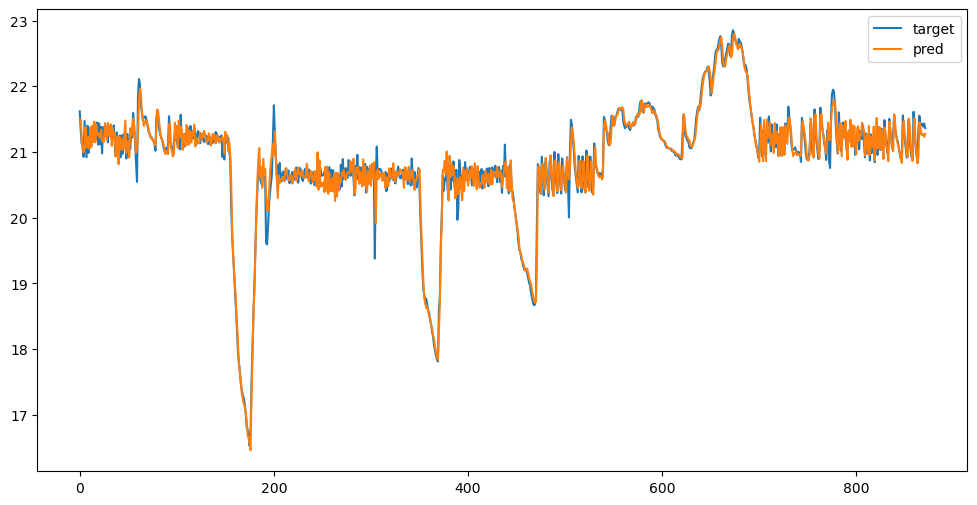

In [27]:
plt.figure(figsize=(12,6))
plt.plot(target_train[:,:], label='target')
plt.plot(y_pred[:,:], label='pred')
plt.legend()

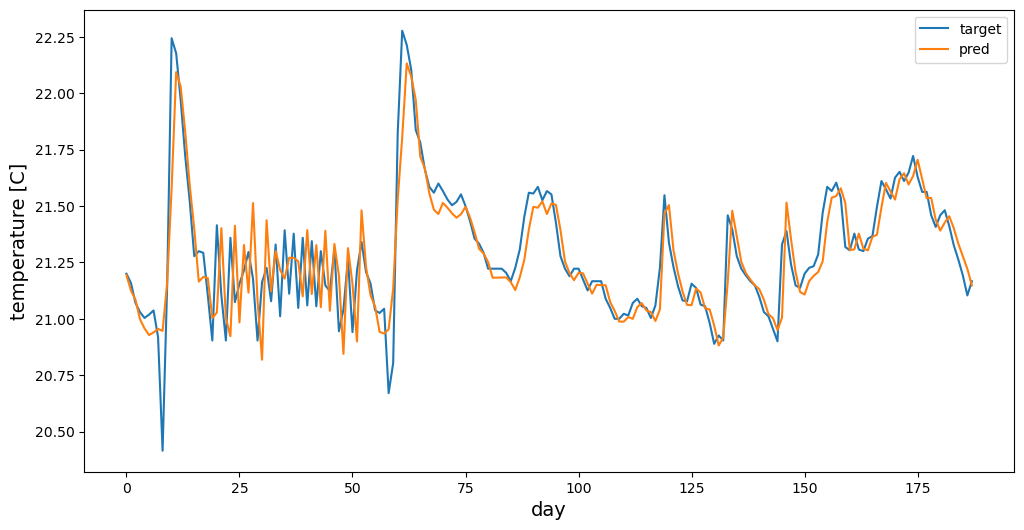

In [28]:
plt.figure(figsize=(12,6))
plt.plot(target_test[:,:], label='target')
plt.plot(y_pred_test[:,:], label='pred')
plt.xlabel('day', fontsize=14)
plt.ylabel('temperature [C]', fontsize=14)
plt.legend()

#### Multi-step Predictions


In [ ]:
horizon = 96 #target_test.shape[0]

# recursively predict future using auto-regressive approach
y_pred_horizon = []
target_horizon = []
num_samples = target_test.shape[0]
for t in range(num_samples - horizon + 1):
    y_pred_future = []
    target_future = []
    
    state_prev = state_init_test[[t]] # (1, Nx)
    for h in range(horizon):
        # state_init_train, u_train, d_train
        state_next = model.apply(train_state.params, state_prev, u_test[[t+h]], d_test[[t+h]])
        # save for plot
        y_pred_future.append(state_next)
        target_future.append(target_test[[t+h]])
        # update
        state_prev = state_next[:]

    y_pred_future = jnp.concatenate(y_pred_future, axis=0)
    target_future = jnp.concatenate(target_future, axis=0)

    y_pred_horizon.append(y_pred_future)
    target_horizon.append(target_future)

y_pred_horizon = jnp.stack(y_pred_horizon, axis=0)
target_horizon = jnp.stack(target_horizon, axis=0)

print(y_pred_horizon.shape)
print("ph={}: test mse is {}".format(horizon, jnp.mean((y_pred_horizon - target_horizon)**2)))

In [ ]:
# add five subplots: at each step, predict the next horizon steps
samples = [0, 24, 48, 72, 96]
plt.subplots(len(samples), 1, figsize=(12, 3*len(samples)))
for i in len(samples):
    plt.subplot(len(samples), 1, 1)
    plt.plot(target_horizon[samples[0]], label='target')
    plt.plot(y_pred_horizon[samples[0]], label='pred')
    plt.legend()
    plt.title(f"step {samples[0]}")
    plt.xlabel('step', fontsize=14)
    plt.ylabel('temperature [C]', fontsize=14)
    plt.tight_layout()

plt.savefig(result_folder + "/test_predict.png")


## Physics-Consistent Check

How to know if the learned model follows general physics? 
- the derivative of room temp with respect to the HVAC energy rate should be positive. The more heat injected to the room, the higher the room temperature.

In [47]:
sample_index = [200]

u_fake = u_train[sample_index, :]
state_init_fake = state_init_train[sample_index, :]
d_fake = d_train[sample_index, :]



In [48]:
state_init_fake.shape, u_fake.shape, d_fake.shape

((1, 1), (1, 1), (1, 6))

In [49]:
# prepare faked inputs for physical simukation check
u = jnp.array([i for i in range(-10, 10)]).reshape(-1, 1) # (B, nu)
n_points = len(u)

state_init = jnp.tile(state_init_fake, (n_points, 1)) # (B, nx)
d = jnp.tile(d_fake, (n_points, 1)) # (B, nd)


In [50]:
y_pred = model.apply(train_state.params, state_init, u, d)

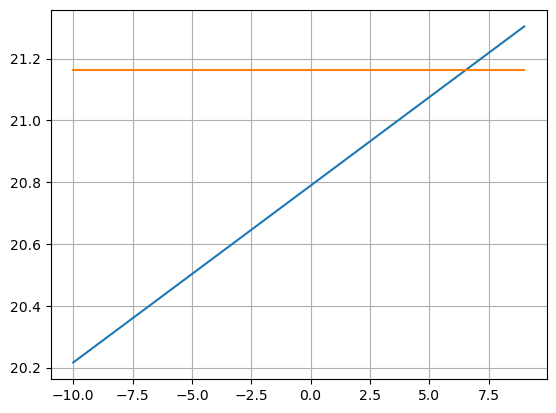

In [51]:
plt.figure()
plt.plot(u.squeeze(), y_pred, label='predicted') #
plt.plot(u.squeeze(), state_init, label='previous temp') # previous temperature
plt.grid()